In [9]:
import dill

In [60]:
dill.dump_session("8notebook_env_new.db")
#dill.load_session("8notebook_env_new.db")

# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

In [8]:
# loading required libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn import model_selection

## 1.1 Reading Data

In [10]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [11]:
print("Number of data points in train data", project_data.shape)
print('-'*60)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
------------------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [12]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]

#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])  #used to convert into datetime object
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)

# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]

project_data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   
76127       37728  p043609  3f60494c61921b3b43ab61bdde2904df            Ms.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   
76127           UT 2016-04-27 00:31:25             Grades 3-5   

      project_subject_categories            project_subject_subcategories  \
55660             Math & Science  Applied Sciences, Health & Life Science   
76127              Special Needs                            Special Needs   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   
76127                       Sensory Tools for Focus   

                                         project_essay_1  \
55660  I have been fortunate enough to use the Fairy ...   
76127  Imagine being 8-9 years old. You're in your th...   

                                         project_essay_2  \
55660  My students come from a variety of backgrounds...   
76127  Most of my students have autism, anxiety, anot...   

                                         project_essay_3  \
55660  Each month I try to do several science or STEM...   
76127  It is tough to do more than one thing at a tim...   

                                         project_essay_4  \
55660  It is challenging to develop high quality scie...   
76127  When my students are able to calm themselves d...   

                                project_resource_summary  \
55660  My students need STEM kits to learn critical s...   
76127  My students need Boogie Boards for quiet senso...   

       teacher_number_of_previously_posted_projects  project_is_approved  
55660                                            53                    1  
76127                                             4                    1

In [13]:
print("Number of data points in resource train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in resource train data (1541272, 4)
['id' 'description' 'quantity' 'price']


id                                        description  quantity  \
0  p233245  LC652 - Lakeshore Double-Space Mobile Drying Rack         1   
1  p069063        Bouncy Bands for Desks (Blue support pipes)         3   

    price  
0  149.00  
1   14.95

## 1.2 preprocessing of `project_subject_categories`

In [14]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [15]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

## 1.3 Text preprocessing

In [16]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)
project_data.drop(['project_essay_1','project_essay_2', 'project_essay_3', 'project_essay_4'], axis=1, inplace=True)

In [17]:
project_data.drop(['project_resource_summary'], axis=1, inplace=True)
project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   

                                                   essay  
55660  I have been fortunate enough to use the Fairy ...

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent = decontracted(project_data['essay'].values[20000])
# print(sent)
# print("="*50)

In [20]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
# print(sent)

In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
# print(sent)

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

<h2><font color='red'> 1.4.1 Preprocessing of `essays`</font></h2>

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:21<00:00, 1341.33it/s]


In [24]:
# after preprocesing we drop some coloums which we don't use from now on
project_data['preprocessed_essays'] = preprocessed_essays
project_data.drop(['essay'], axis=1, inplace=True)

project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

                                      project_title  \
55660  Engineering STEAM into the Primary Classroom   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   

                                     preprocessed_essays  
55660  fortunate enough use fairy tale stem kits clas...

<h2><font color='red'> 1.4.2 Preprocessing of `project_title`</font></h2>

In [25]:
# preprocessing project titles
from tqdm import tqdm
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:03<00:00, 34950.51it/s]


In [26]:
# droping coloums project_titles and project_resource_summary which we don't want to use
project_data['preprocessed_titles'] = preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
55660        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           Mrs.   

      school_state                Date project_grade_category  \
55660           CA 2016-04-27 00:27:36          Grades PreK-2   

       teacher_number_of_previously_posted_projects  project_is_approved  \
55660                                            53                    1   

      clean_categories                 clean_subcategories  \
55660     Math_Science  AppliedSciences Health_LifeScience   

                                     preprocessed_essays  \
55660  fortunate enough use fairy tale stem kits clas...   

                       preprocessed_titles  
55660  engineering steam primary classroom

### preprocessing of project_grade_category

In [27]:
# preprocessing of preoject_grade_category
from tqdm import tqdm
preprocessed_pgc = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_grade_category'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = '_'.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_pgc.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:02<00:00, 37574.53it/s]


In [28]:
project_data['preprocessed_pgc'] = preprocessed_pgc
project_data.drop(['project_grade_category'], axis=1, inplace=True)

### preprocessing of teacher_prefix categorical feature

In [29]:
# preprocessing of teacher prefix
from tqdm import tqdm
preprocessed_tp = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['teacher_prefix'].values):
    sent = decontracted(str(sentance))
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = '_'.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_tp.append(sent.lower().strip())

100%|██████████| 109248/109248 [00:01<00:00, 55789.29it/s]


In [30]:
project_data['preprocessed_tp'] = preprocessed_tp
project_data.drop(['teacher_prefix'], axis=1, inplace=True)

In [31]:
# Merging Project_data and price data dataframe  
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
project_data = pd.merge(project_data, price_data, on='id', how='left')
project_data.head(2)

Unnamed: 0       id                        teacher_id school_state  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   
1       37728  p043609  3f60494c61921b3b43ab61bdde2904df           UT   

                 Date  teacher_number_of_previously_posted_projects  \
0 2016-04-27 00:27:36                                            53   
1 2016-04-27 00:31:25                                             4   

   project_is_approved clean_categories                 clean_subcategories  \
0                    1     Math_Science  AppliedSciences Health_LifeScience   
1                    1     SpecialNeeds                        SpecialNeeds   

                                 preprocessed_essays  \
0  fortunate enough use fairy tale stem kits clas...   
1  imagine 8 9 years old third grade classroom se...   

                   preprocessed_titles preprocessed_pgc preprocessed_tp  \
0  engineering steam primary classroom    grades_prek_2             mrs   
1                  sensory tools focus       grades_3_5              ms   

    price  quantity  
0  725.05         4  
1  213.03         8

In [32]:
project_data['project_is_approved'].value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

Since Number of data points for which are project is approved is much greater than the number of data points for which project is not approved so this is imbalence dataset.

## 1.5 Preparing data for models

In [33]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'school_state', 'Date',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'preprocessed_essays',
       'preprocessed_titles', 'preprocessed_pgc', 'preprocessed_tp', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

# Assignment 8: DT

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features + project_title(BOW) + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 3</font>: categorical, numerical features + project_title(AVG W2V)+  preprocessed_eassay (AVG W2V)</li>
            <li><font color='red'>Set 4</font>: categorical, numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li> 
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud <a href='https://www.geeksforgeeks.org/generating-word-cloud-python/' with the words of eassy text of these `false positive data points`>WordCloud</a></li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>[Task-2]</strong>
        <ul>
    <li> Select 5k best features from features of <font color='red'>Set 2</font> using<a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>`feature_importances_`</a>, discard all the other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3</li>
        </ul>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakage, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

<h1>2. Decision Tree </h1>

In [34]:
project_data.head(1)

Unnamed: 0       id                        teacher_id school_state  \
0        8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5           CA   

                 Date  teacher_number_of_previously_posted_projects  \
0 2016-04-27 00:27:36                                            53   

   project_is_approved clean_categories                 clean_subcategories  \
0                    1     Math_Science  AppliedSciences Health_LifeScience   

                                 preprocessed_essays  \
0  fortunate enough use fairy tale stem kits clas...   

                   preprocessed_titles preprocessed_pgc preprocessed_tp  \
0  engineering steam primary classroom    grades_prek_2             mrs   

    price  quantity  
0  725.05         4

In [35]:
y = project_data['project_is_approved'].values
X = project_data.drop(['project_is_approved'], axis=1)

<h2>2.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [36]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [37]:
print(X_train.shape)
print(y_train.shape)
print(X_cv.shape)
print(y_cv.shape)
print(X_test.shape)
print(y_test.shape)

(69918, 14)
(69918,)
(17480, 14)
(17480,)
(21850, 14)
(21850,)


<h2>2.2 Make Data Model Ready: encoding numerical, categorical features</h2>

## 2.2.1 one hot encoding the categorical features: school_state

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [38]:
# one hot encoding of school_state for training, cv and test data  
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
school_state_fn = vectorizer.get_feature_names()
print(school_state_fn)

After vectorizations
(69918, 51) (69918,)
(17480, 51) (17480,)
(21850, 51) (21850,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


## 2.2.2 one hot encoding the categorical features: clean_categories

In [39]:
# one hot encoding of clean_categories for training, cv and test data  
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_categories_ohe.shape, y_train.shape)
print(X_cv_categories_ohe.shape, y_cv.shape)
print(X_test_categories_ohe.shape, y_test.shape)
categories_fn = vectorizer.get_feature_names()
print(categories_fn)

After vectorizations
(69918, 9) (69918,)
(17480, 9) (17480,)
(21850, 9) (21850,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


## 2.2.3 one hot encoding the categorical features: clean_subcategories

In [40]:
# one hot encoding of clean_subcategories for training, cv and test data  
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategories_ohe.shape, y_train.shape)
print(X_cv_subcategories_ohe.shape, y_cv.shape)
print(X_test_subcategories_ohe.shape, y_test.shape)
subcategories_fn = vectorizer.get_feature_names()
print(subcategories_fn)

After vectorizations
(69918, 30) (69918,)
(17480, 30) (17480,)
(21850, 30) (21850,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


## 2.2.4 one hot encoding the categorical features: teacher_prefix

In [41]:
# one hot encoding of teacher_prefix for training, cv and test data  
temp_tp_all = list(set(X_train['preprocessed_tp'].values))
temp_tp_all.remove('nan')

vectorizer = CountVectorizer()
#https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
vectorizer.fit(temp_tp_all) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_prefix_ohe = vectorizer.transform(X_train['preprocessed_tp'].values)
X_cv_teacher_prefix_ohe = vectorizer.transform(X_cv['preprocessed_tp'].values)
X_test_teacher_prefix_ohe = vectorizer.transform(X_test['preprocessed_tp'].values)

print("After vectorizations")
print(X_train_teacher_prefix_ohe.shape, y_train.shape)
print(X_cv_teacher_prefix_ohe.shape, y_cv.shape)
print(X_test_teacher_prefix_ohe.shape, y_test.shape)
teacher_prefix_fn = vectorizer.get_feature_names()
print(teacher_prefix_fn)

After vectorizations
(69918, 5) (69918,)
(17480, 5) (17480,)
(21850, 5) (21850,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


## 2.2.5 one hot encoding the categorical features: project_grade_category

In [42]:
# one hot encoding of project_grade_category for training, cv and test data  
vectorizer = CountVectorizer()
vectorizer.fit(X_train['preprocessed_pgc'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pgc_ohe = vectorizer.transform(X_train['preprocessed_pgc'].values)
X_cv_pgc_ohe = vectorizer.transform(X_cv['preprocessed_pgc'].values)
X_test_pgc_ohe = vectorizer.transform(X_test['preprocessed_pgc'].values)

print("After vectorizations")
print(X_train_pgc_ohe.shape, y_train.shape)
print(X_cv_pgc_ohe.shape, y_cv.shape)
print(X_test_pgc_ohe.shape, y_test.shape)
pgc_fn = vectorizer.get_feature_names()
print(pgc_fn)

After vectorizations
(69918, 4) (69918,)
(17480, 4) (17480,)
(21850, 4) (21850,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


## 2.2.6 Normalizing the numerical features: Price

In [43]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
price_fn = ['price']
print(price_fn)

After vectorizations
(69918, 1) (69918,)
(17480, 1) (17480,)
(21850, 1) (21850,)
['price']


## 2.2.7 Normalizing the numerical features: teacher_number_of_previously_posted_projects

In [44]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_tnppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_tnppp_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_tnppp_norm.shape, y_train.shape)
print(X_cv_tnppp_norm.shape, y_cv.shape)
print(X_test_tnppp_norm.shape, y_test.shape)
tnppp_fn = ['teacher_number_of_previously_posted_projects']
print(tnppp_fn)

After vectorizations
(69918, 1) (69918,)
(17480, 1) (17480,)
(21850, 1) (21850,)
['teacher_number_of_previously_posted_projects']


## 2.2.8 Normalizing the numerical features: quantity

In [45]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)
quantity_fn = ['quantity']
print(quantity_fn)

After vectorizations
(69918, 1) (69918,)
(17480, 1) (17480,)
(21850, 1) (21850,)
['quantity']


<h2>2.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [46]:
X_train.head(2)

Unnamed: 0       id                        teacher_id school_state  \
6411       125264  p013348  a8b17d20114df09ad0d20dd6c8dbed37           MO   
17902       70877  p119033  d0ba613d183f96a22a0ee277fa103487           TX   

                     Date  teacher_number_of_previously_posted_projects  \
6411  2016-05-31 13:39:47                                            16   
17902 2016-07-25 22:18:02                                             0   

                     clean_categories             clean_subcategories  \
6411   Literacy_Language Math_Science  Literature_Writing Mathematics   
17902               Literacy_Language     Literacy Literature_Writing   

                                     preprocessed_essays preprocessed_titles  \
6411   awesome students lot students not stable homes...       desks success   
17902  live wonderful community involved much school ...           ipads pad   

      preprocessed_pgc preprocessed_tp   price  quantity  
6411     grades_prek_2              ms   62.09         8  
17902       grades_3_5             mrs  782.23        10

#### Bag of words for essays

In [47]:
# We are considering only the words which appeared in at least 10 documents(rows or projects)
vectorizer = CountVectorizer(min_df=10, max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
essays_bog_fn = vectorizer.get_feature_names()
print(len(essays_bog_fn))

After vectorizations
(69918, 5000) (69918,)
(17480, 5000) (17480,)
(21850, 5000) (21850,)
5000


#### Bag of words for titles

In [48]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_titles'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['preprocessed_titles'].values)
X_cv_title_bow = vectorizer.transform(X_cv['preprocessed_titles'].values)
X_test_title_bow = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
title_bog_fn = vectorizer.get_feature_names()
print(len(title_bog_fn))

After vectorizations
(69918, 2440) (69918,)
(17480, 2440) (17480,)
(21850, 2440) (21850,)
2440


#### TFIDF vectorizer for essays

In [49]:
# tfidf vectorizer on project essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,  max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values)


# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
essays_tfidf_fn = vectorizer.get_feature_names()
print(len(essays_tfidf_fn))

After vectorizations
(69918, 5000) (69918,)
(17480, 5000) (17480,)
(21850, 5000) (21850,)
5000


#### TFIDF vectorizer for titles

In [50]:
# tfidf vectorizer on project titles
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['preprocessed_titles'].values)


# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['preprocessed_titles'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['preprocessed_titles'].values)
X_test_title_tfidf = vectorizer.transform(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_cv_title_tfidf.shape, y_cv.shape)
print(X_test_title_tfidf.shape, y_test.shape)
title_tfidf_fn = vectorizer.get_feature_names()
print(len(title_tfidf_fn))

After vectorizations
(69918, 2440) (69918,)
(17480, 2440) (17480,)
(21850, 2440) (21850,)
2440


#### Using Pretrained Models: Avg W2V for essays

In [51]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [52]:
def convert_avg_w2v(temp_list_essay):
    # average Word2Vec for preprocessed essays
    # compute average word2vec for each review.
    text_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
    for sentence in tqdm(temp_list_essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        cnt_words = 0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if word in glove_words:
                vector += model[word]
                cnt_words += 1
        if cnt_words != 0:
            vector /= cnt_words
        text_avg_w2v.append(vector)
    return text_avg_w2v


In [53]:
X_train_essay_avgw2v = convert_avg_w2v(X_train['preprocessed_essays'].values)
X_cv_essay_avgw2v = convert_avg_w2v(X_cv['preprocessed_essays'].values)
X_test_essay_avgw2v = convert_avg_w2v(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(len(X_train_essay_avgw2v), y_train.shape)
print(len(X_cv_essay_avgw2v), y_cv.shape)
print(len(X_test_essay_avgw2v), y_test.shape)

100%|██████████| 21850/21850 [00:08<00:00, 2659.99it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)


#### Using Pretrained Models: Avg W2V for titles

In [54]:
# average Word2Vec for preprocessed titles
X_train_title_avgw2v = convert_avg_w2v(X_train['preprocessed_titles'].values)
X_cv_title_avgw2v = convert_avg_w2v(X_cv['preprocessed_titles'].values)
X_test_title_avgw2v = convert_avg_w2v(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(len(X_train_title_avgw2v), y_train.shape)
print(len(X_cv_title_avgw2v), y_cv.shape)
print(len(X_test_title_avgw2v), y_test.shape)
print(len(X_train_title_avgw2v[0]))
print(len(X_cv_title_avgw2v[0]))
print(len(X_test_title_avgw2v[0]))

100%|██████████| 21850/21850 [00:00<00:00, 56037.75it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)
300
300
300


#### Using Pretrained Models: TFIDF weighted W2V for essays

In [55]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [56]:
def convert_tfidf_w_w2v(temp_list_essay):
    # tfidf weighted Word2Vec
    # compute tfidf weighted word2vec for each review.
    text_tfidf_w_w2v = []; # the tfid weighted w2v for each sentence/review is stored in this list
    for sentence in tqdm(temp_list_essay): # for each review/sentence
        vector = np.zeros(300) # as word vectors are of zero length
        tf_idf_weight =0; # num of words with a valid vector in the sentence/review
        for word in sentence.split(): # for each word in a review/sentence
            if (word in glove_words) and (word in tfidf_words):
                vec = model[word] # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        text_tfidf_w_w2v.append(vector)
    return text_tfidf_w_w2v

In [57]:
X_train_essay_tww2v = convert_tfidf_w_w2v(X_train['preprocessed_essays'].values)
X_cv_essay_tww2v = convert_tfidf_w_w2v(X_cv['preprocessed_essays'].values)
X_test_essay_tww2v = convert_tfidf_w_w2v(X_test['preprocessed_essays'].values)

print("After vectorizations")
print(len(X_train_essay_tww2v), y_train.shape)
print(len(X_cv_essay_tww2v), y_cv.shape)
print(len(X_test_essay_tww2v), y_test.shape)

100%|██████████| 21850/21850 [00:59<00:00, 369.93it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)


#### Using Pretrained Models: TFIDF weighted W2V for titles

In [58]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_titles'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [59]:
X_train_titles_tww2v = convert_tfidf_w_w2v(X_train['preprocessed_titles'].values)
X_cv_titles_tww2v = convert_tfidf_w_w2v(X_cv['preprocessed_titles'].values)
X_test_titles_tww2v = convert_tfidf_w_w2v(X_test['preprocessed_titles'].values)

print("After vectorizations")
print(len(X_train_titles_tww2v), y_train.shape)
print(len(X_cv_titles_tww2v), y_cv.shape)
print(len(X_test_titles_tww2v), y_test.shape)

100%|██████████| 21850/21850 [00:00<00:00, 24561.73it/s]

After vectorizations
69918 (69918,)
17480 (17480,)
21850 (21850,)


<h2>2.4 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

### 2.4.1 Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [129]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_bow, X_train_title_bow, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_bow, X_cv_title_bow, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_bow, X_test_title_bow, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7541) (69918,)
(17480, 7541) (17480,)
(21850, 7541) (21850,)


In [130]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100, 500]
param_grid = dict(max_depth = depth, min_samples_split = min_samples_split)

clf_ = DecisionTreeClassifier(class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(min_samples_split))
cv_score_reshaped = cv_score.reshape(len(depth), len(min_samples_split))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

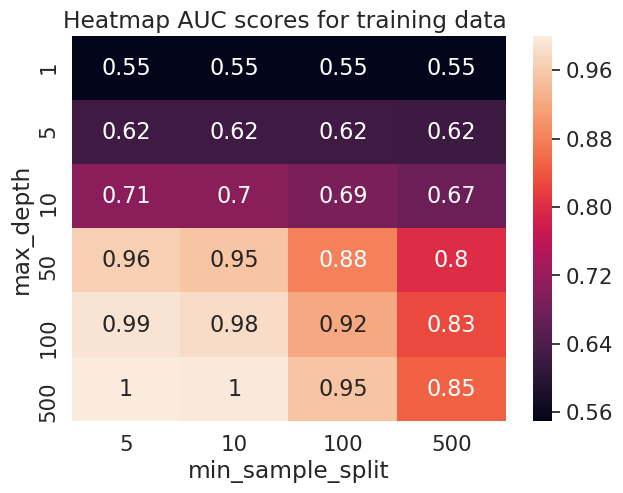

In [131]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

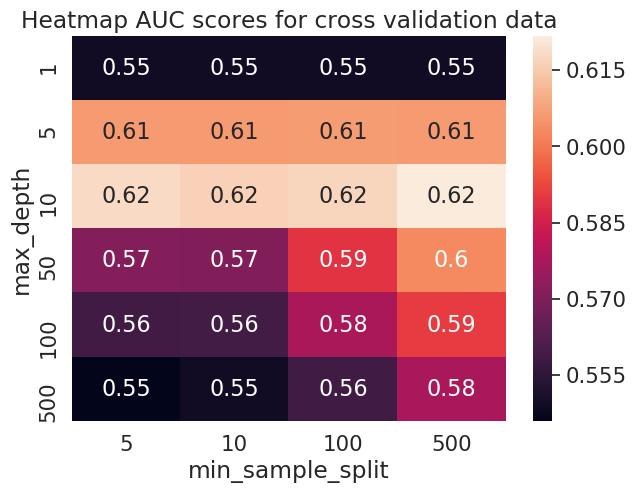

In [132]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7,5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### we find best max_depth = 10 with min_sample_split = 500.

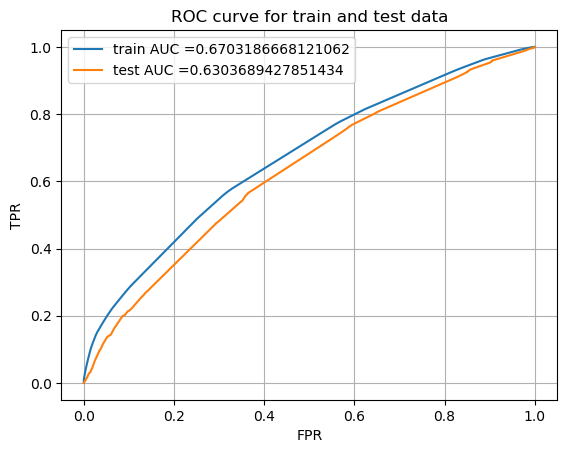

In [107]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth=10, min_samples_split = 500)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

Here train AUC is higher than the test auc that means this model is overfitting on the train data.

##### Drawing confusion matrix

In [108]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [109]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.3882764917237512 for threshold 0.48
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3593175896494079 for threshold 0.48


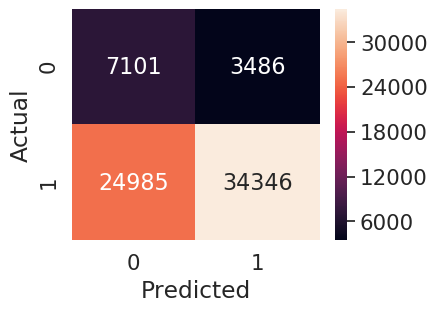

In [110]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
array = cmtr       
df_cm = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize = (4,3))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')# font size

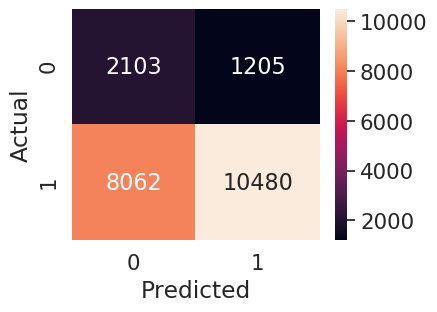

In [111]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

In [112]:
# Store all feature names in a list all_features_bag in the same order in which they appear in hstack function 
all_features_bag = []

all_features_bag.extend(essays_bog_fn)
all_features_bag.extend(title_bog_fn)

all_features_bag.extend(school_state_fn)
all_features_bag.extend(categories_fn)
all_features_bag.extend(subcategories_fn)
all_features_bag.extend(teacher_prefix_fn)
all_features_bag.extend(pgc_fn)

all_features_bag.extend(price_fn)
all_features_bag.extend(tnppp_fn)
print(len(all_features_bag))

7541


#### 2.4.1.1 Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

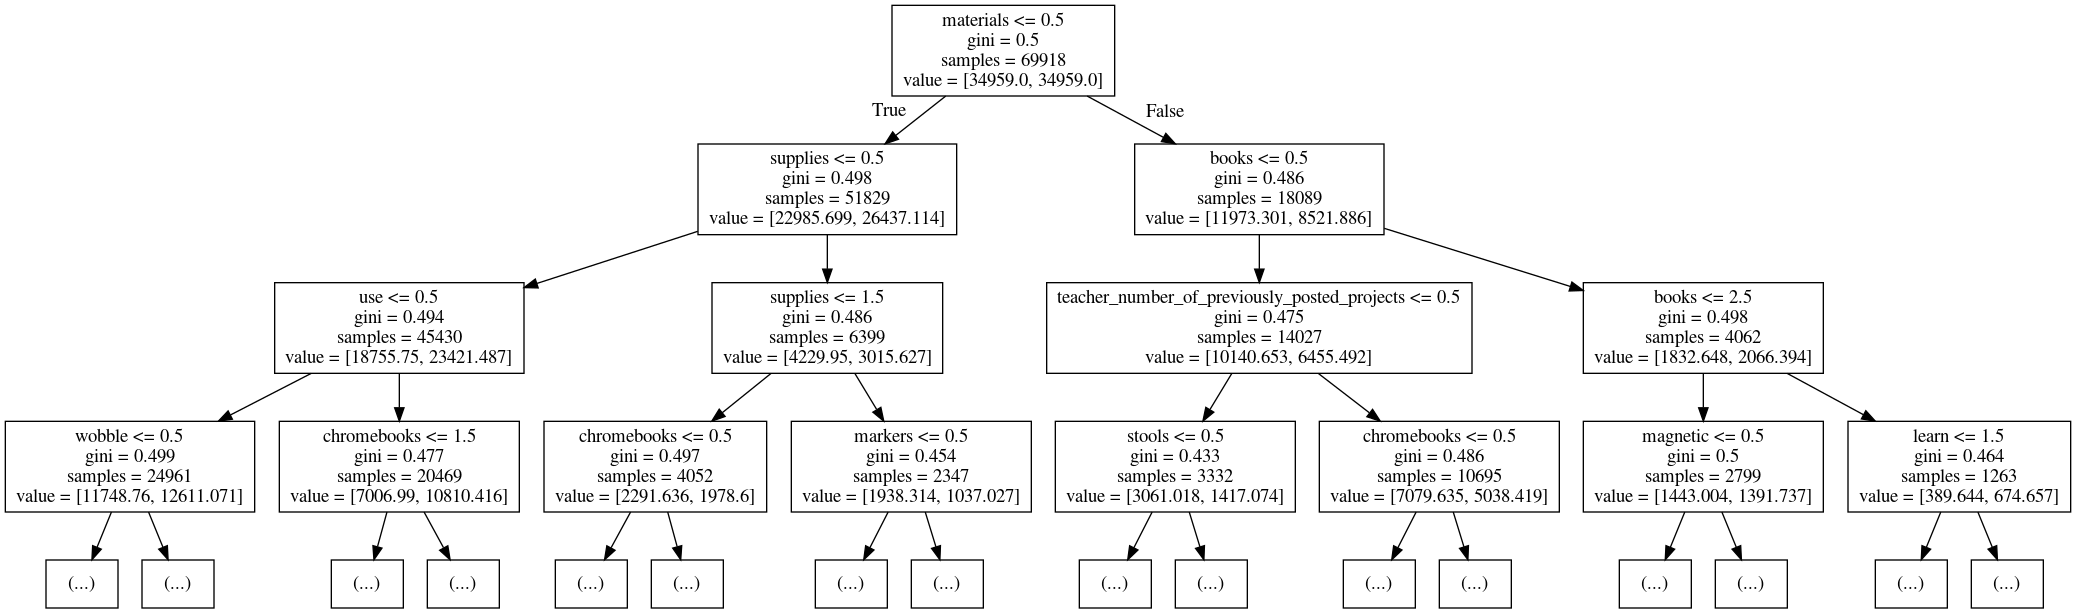

In [115]:
#source https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/
# importing required libraries
from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, max_depth = 3,feature_names = all_features_bag)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

### Selection and operations on false possitive data points
<li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud <a href='https://www.geeksforgeeks.org/generating-word-cloud-python/' with the words of eassy text of these `false positive data points`>WordCloud</a></li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
    </li>

In [180]:
# Getting all indexes of false possitive data points for test data
index_of_false_positive_data_points_test = [] 
y_test_pred_class = predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)
for i in range(y_test.shape[0]):
    if y_test[i] == 0 and y_test_pred_class[i] == 1:
        index_of_false_positive_data_points_test.append(i)
    else:
        pass

print(len(index_of_false_positive_data_points_test))

# Selecting all the rows or data points from test data which gives false possitive result.
X_test_false_positive = X_test.iloc[index_of_false_positive_data_points_test]

the maximum value of tpr*(1-fpr) 0.35379321849399187 for threshold 0.474
1901


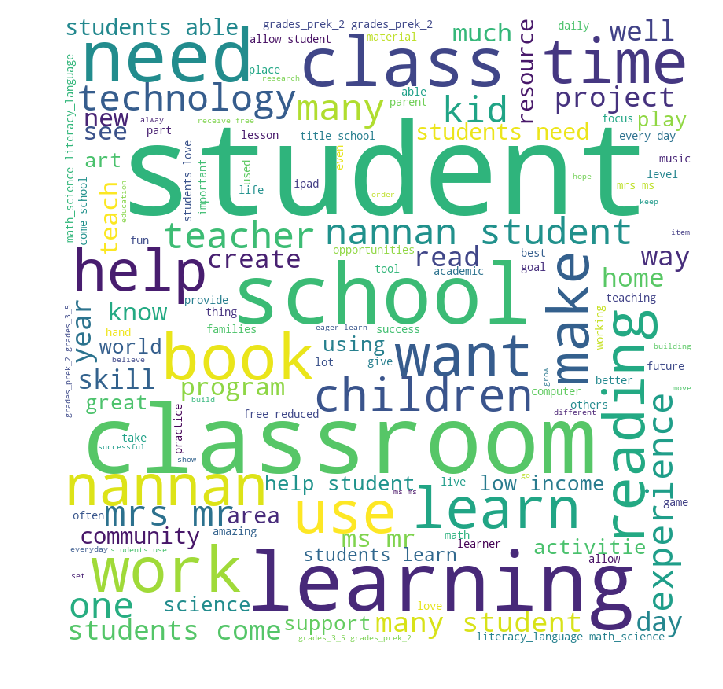

In [181]:
# ploting the wordcloud for all false positive data points for test data
# source https://www.geeksforgeeks.org/generating-word-cloud-python/

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

column_select = ['school_state','clean_categories','clean_subcategories','preprocessed_essays',
                 'preprocessed_titles','preprocessed_pgc','preprocessed_tp']

all_words_false_positive = ' '
stopwords = set(STOPWORDS) 
  
# iterate through all the data
for col_name in column_select:
    for val in X_test_false_positive[col_name].values:
        
        # type cast each value to string
        val = str(val)
        
        #split the value
        tokens = val.split()
        
        #convert each tokens into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            
        for words in tokens:
            all_words_false_positive = all_words_false_positive + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_words_false_positive) 
  

# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

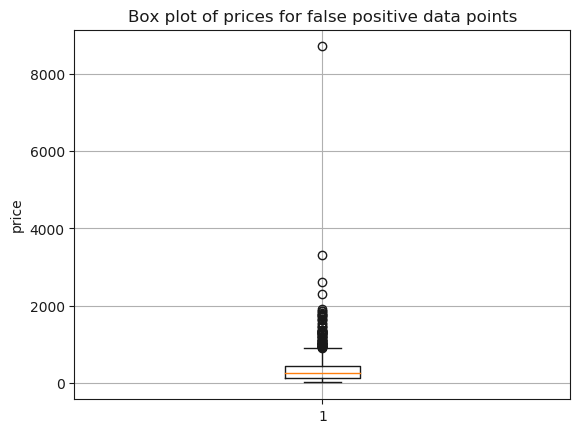

In [182]:
# Plotting the box plot with the `price` of these `false positive data points`
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.boxplot(X_test_false_possitive['price'].values)
plt.title("Box plot of prices for false positive data points")
plt.ylabel("price")
plt.grid()
plt.show()

<strong> Observations: </strong>
<ul>
    <li>The range of prices for maximum projects is 0 to 1000 </li>
    <li>75% prices of this class belongs to less than 500 </li>
    <li> There are some project prices which are greater than 1000 </li>
</ul>

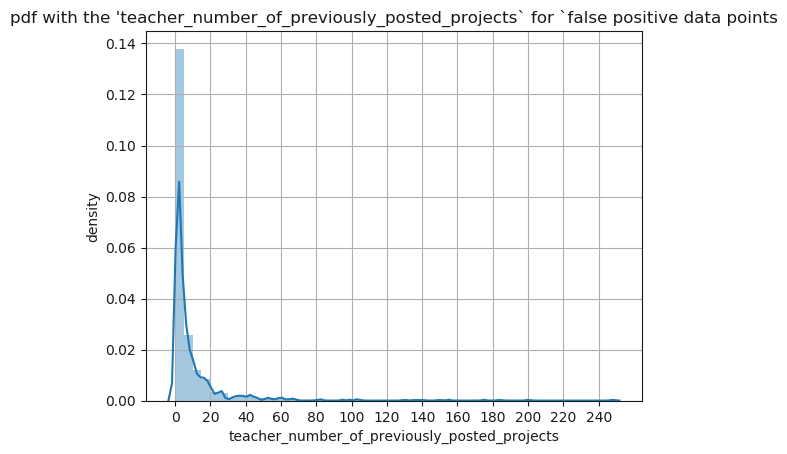

In [183]:
# Density Plot and Histogram of all arrival delays
import seaborn as sns
sns.distplot(X_test_false_possitive['teacher_number_of_previously_posted_projects'].values, hist = True)
plt.title("pdf with the 'teacher_number_of_previously_posted_projects` for `false positive data points")
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.ylabel("density")
plt.grid()
plt.xticks(np.arange(0, 250, step=20))
plt.show()

Observation: <br>
1 - 5 projects are previously posted by maximum number of teachers <br>
2 - For most projects in this class number_of_previously_posted_projects are between 0 to 20.

### 2.4.2 Applying DT on TFIDF ,<font color='red'> SET 2</font>

In [133]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7541) (69918,)
(17480, 7541) (17480,)
(21850, 7541) (21850,)


In [134]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100, 500]
param_grid = dict(max_depth = depth, min_samples_split = min_samples_split)

clf_ = DecisionTreeClassifier(class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs = -1)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(min_samples_split))
cv_score_reshaped = cv_score.reshape(len(depth), len(min_samples_split))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

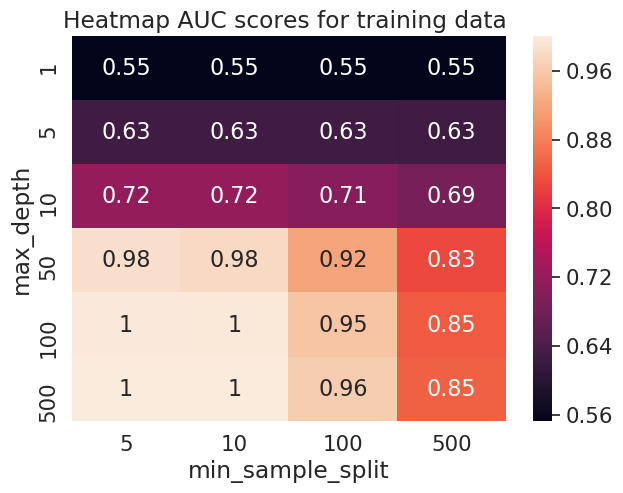

In [135]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

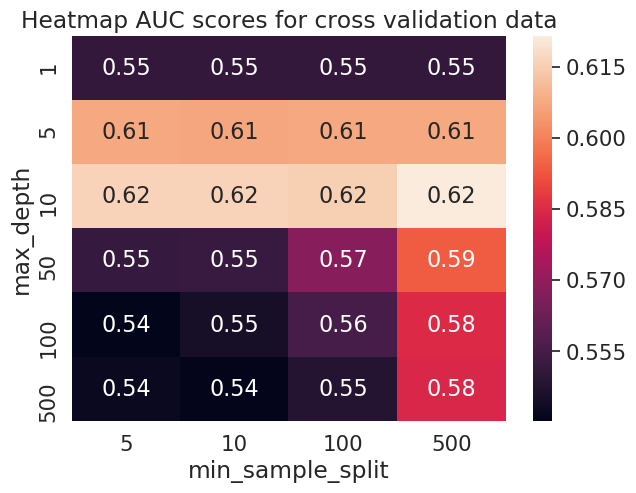

In [136]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7,5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

Hyperparameter tuning using gridsearchcv

#### we find best max_depth = 10 with min_sample_split = 500.

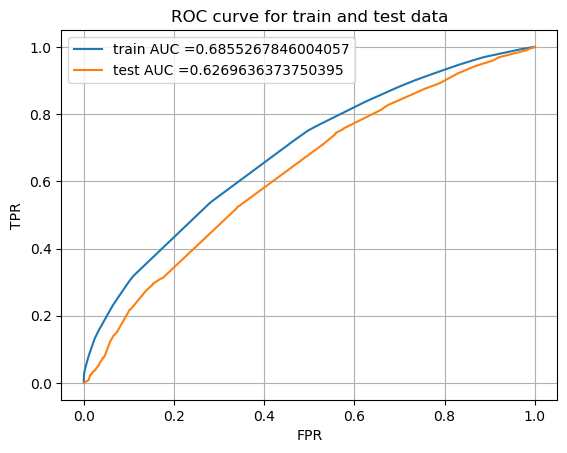

In [121]:

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth=10, min_samples_split = 500)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [122]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [123]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.38683093196422624 for threshold 0.511
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3455734404470415 for threshold 0.552


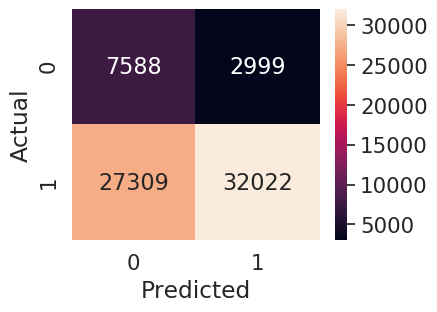

In [124]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

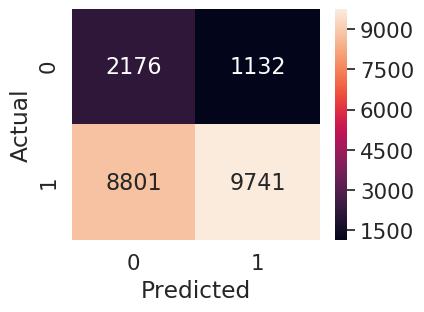

In [125]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (4,3))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

In [126]:
# Store all feature names in a list all_features_bag in the same order in which they appear in hstack function 
all_features_bag = []

all_features_bag.extend(essays_tfidf_fn)
all_features_bag.extend(title_tfidf_fn)

all_features_bag.extend(school_state_fn)
all_features_bag.extend(categories_fn)
all_features_bag.extend(subcategories_fn)
all_features_bag.extend(teacher_prefix_fn)
all_features_bag.extend(pgc_fn)

all_features_bag.extend(price_fn)
all_features_bag.extend(tnppp_fn)
print(len(all_features_bag))

7541


This model with TFIDF correctly classifies 61% of the data points which are belongs to class 0. But only 53% of the data points which belongs to class 1 are correctly classified.

#### 2.4.2.1 Graphviz visualization of Decision Tree on TF-IDF,<font color='red'> SET 2</font>

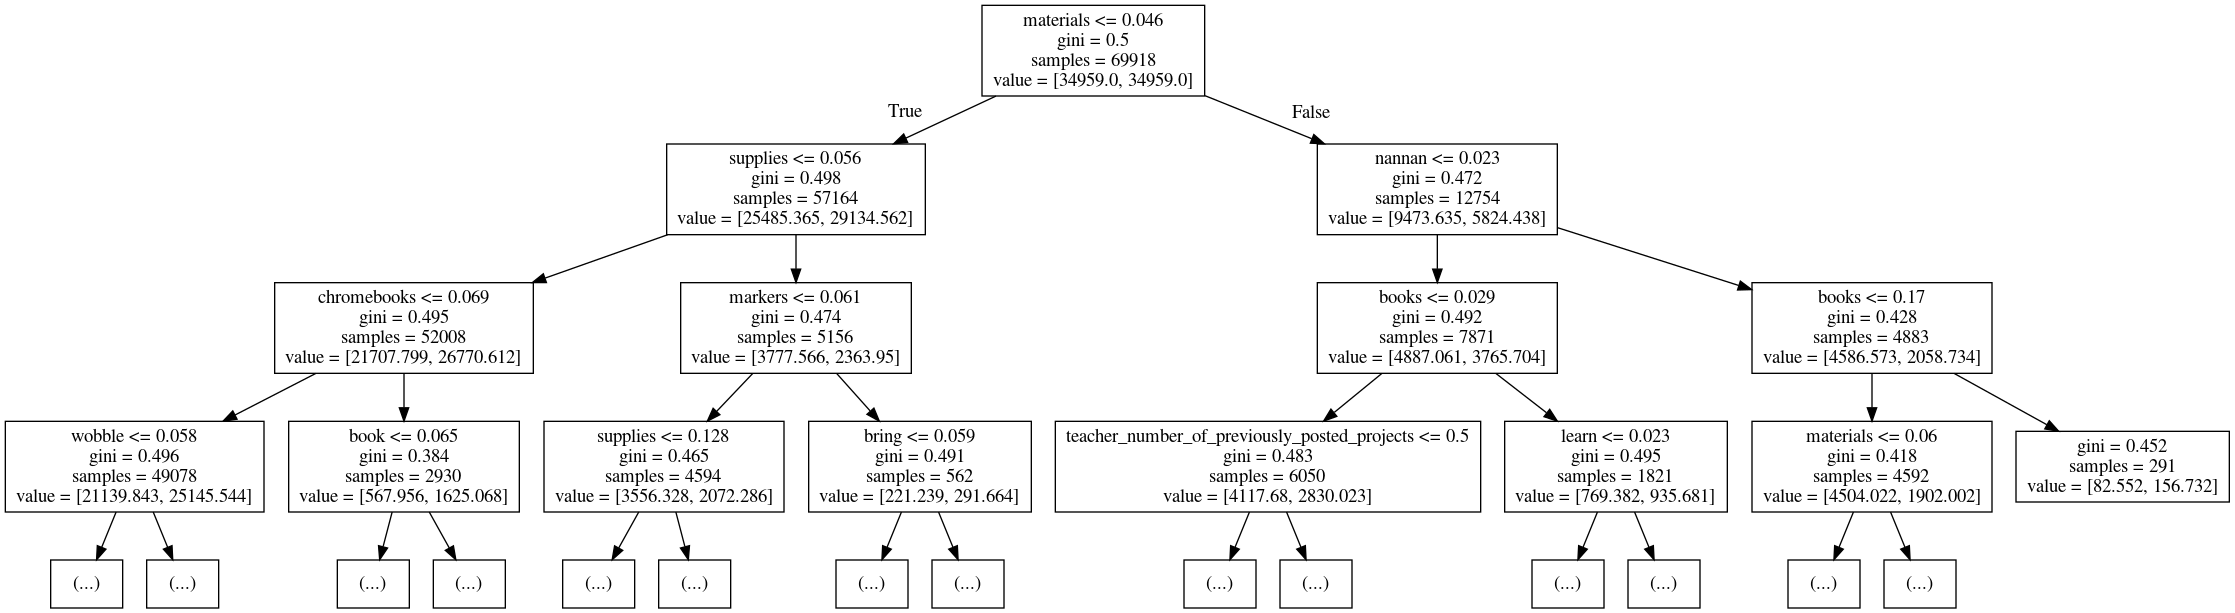

In [128]:
#source https://chrisalbon.com/machine_learning/trees_and_forests/visualize_a_decision_tree/
# importing required libraries
from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, max_depth = 3,feature_names = all_features_bag)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

### Selection and operations on false possitive data points
<li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud <a href='https://www.geeksforgeeks.org/generating-word-cloud-python/' with the words of eassy text of these `false positive data points`>WordCloud</a></li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
    </li>

In [196]:
# Getting all indexes of false possitive data points for test data
index_of_false_positive_data_points_test = [] 
y_test_pred_class = predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)
for i in range(y_test.shape[0]):
    if y_test[i] == 0 and y_test_pred_class[i] == 1:
        index_of_false_positive_data_points_test.append(i)
    else:
        pass

print(len(index_of_false_positive_data_points_test))

# Selecting all the rows or data points from test data which gives false possitive result.
X_test_false_positive = X_test.iloc[index_of_false_positive_data_points_test]

the maximum value of tpr*(1-fpr) 0.34029740253083396 for threshold 0.514
1228


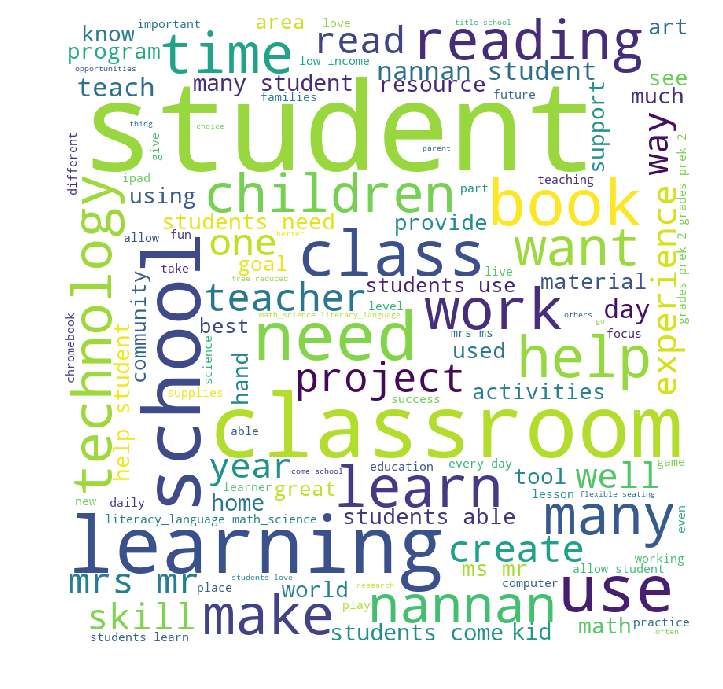

In [197]:
# ploting the wordcloud for all false positive data points for test data
# source https://www.geeksforgeeks.org/generating-word-cloud-python/

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

column_select = ['school_state','clean_categories','clean_subcategories','preprocessed_essays',
                 'preprocessed_titles','preprocessed_pgc','preprocessed_tp']

all_words_false_positive = ' '
stopwords = set(STOPWORDS) 
  
# iterate through all the data
for col_name in column_select:
    for val in X_test_false_positive[col_name].values:
        
        # type cast each value to string
        val = str(val)
        
        #split the value
        tokens = val.split()
        
        #convert each tokens into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            
        for words in tokens:
            all_words_false_positive = all_words_false_positive + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_words_false_positive) 
  

# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

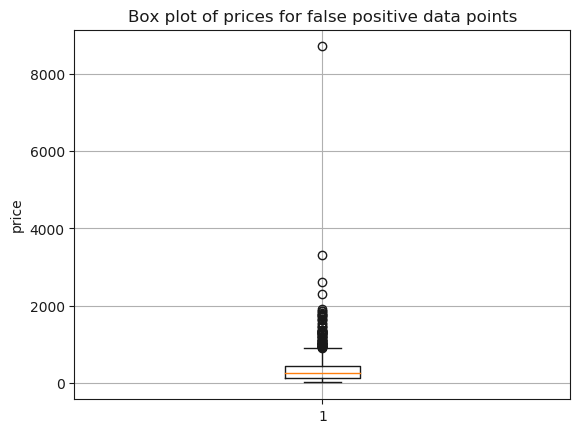

In [198]:
# Plotting the box plot with the `price` of these `false positive data points`
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.boxplot(X_test_false_possitive['price'].values)
plt.title("Box plot of prices for false positive data points")
plt.ylabel("price")
plt.grid()
plt.show()

<strong> Observations: </strong>
<ul>
    <li>The range of prices for maximum projects is 0 to 1000 </li>
    <li>75% prices of this class belongs to less than 500 </li>
    <li> There are some project prices which are greater than 1000 </li>
</ul>

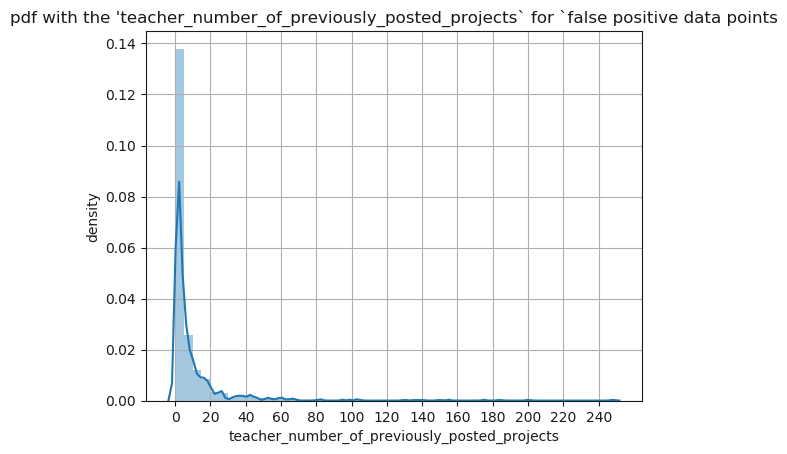

In [199]:
# Density Plot and Histogram of all arrival delays
import seaborn as sns
sns.distplot(X_test_false_possitive['teacher_number_of_previously_posted_projects'].values, hist = True)
plt.title("pdf with the 'teacher_number_of_previously_posted_projects` for `false positive data points")
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.ylabel("density")
plt.grid()
plt.xticks(np.arange(0, 250, step=20))
plt.show()

Observation: <br>
1 - 5 projects are previously posted by maximum number of teachers <br>
2 - For most projects in this class number_of_previously_posted_projects are between 0 to 20.

### 2.4.3 Applying DT on AVG W2V,<font color='red'> SET 3</font>

In [137]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_avgw2v, X_train_title_avgw2v, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_avgw2v, X_cv_title_avgw2v, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_avgw2v, X_test_title_avgw2v, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 701) (69918,)
(17480, 701) (17480,)
(21850, 701) (21850,)


In [138]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100, 500]
param_grid = dict(max_depth = depth, min_samples_split = min_samples_split)

clf_ = DecisionTreeClassifier(class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs=-1)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(min_samples_split))
cv_score_reshaped = cv_score.reshape(len(depth), len(min_samples_split))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

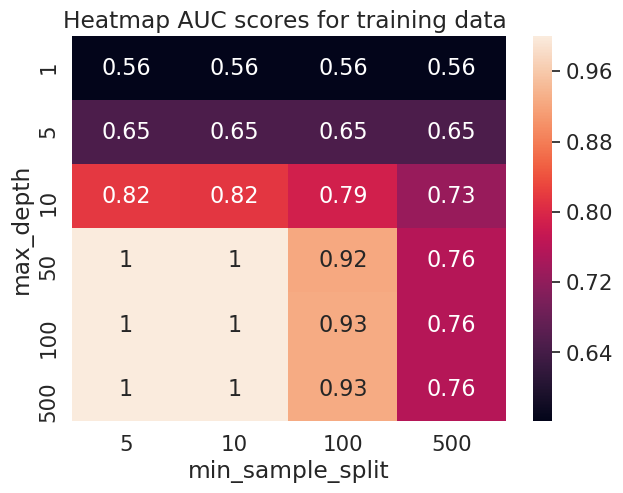

In [139]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

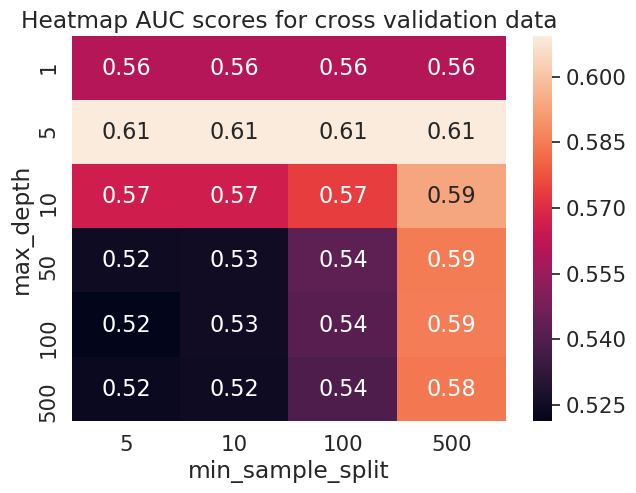

In [140]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7,5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

we choose max_depth = 5 and min_sample_split = 500 to train our final model

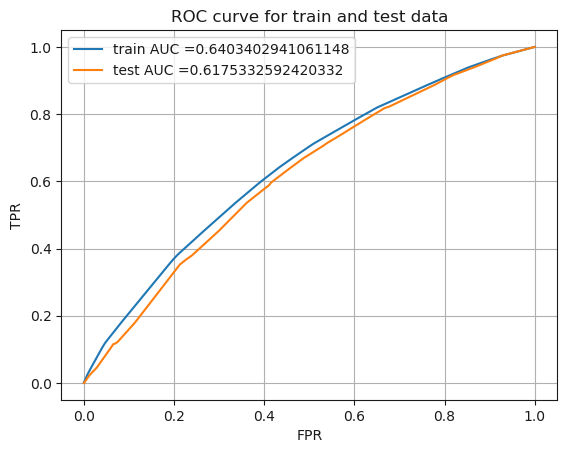

In [202]:

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth=5, min_samples_split = 500)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

Here train AUC is slightly higher than the test auc, But this is considard as a good model. 

##### Drawing confusion matrix

In [203]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [204]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.36394874351809103 for threshold 0.521
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.34868965414248937 for threshold 0.521


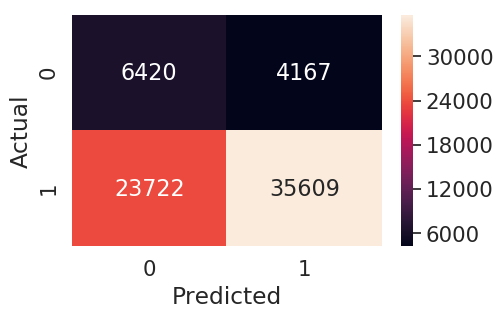

In [205]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

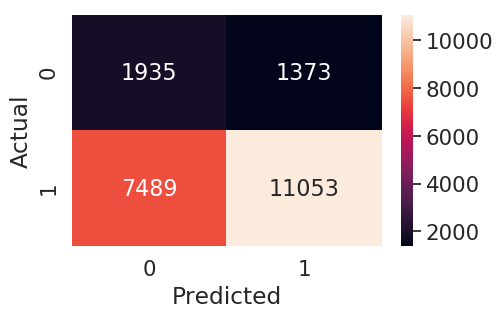

In [206]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

### Selection and operations on false possitive data points
<li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud <a href='https://www.geeksforgeeks.org/generating-word-cloud-python/' with the words of eassy text of these `false positive data points`>WordCloud</a></li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
    </li>

In [207]:
# Getting all indexes of false possitive data points for test data
index_of_false_positive_data_points_test = [] 
y_test_pred_class = predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)
for i in range(y_test.shape[0]):
    if y_test[i] == 0 and y_test_pred_class[i] == 1:
        index_of_false_positive_data_points_test.append(i)
    else:
        pass

print(len(index_of_false_positive_data_points_test))

# Selecting all the rows or data points from test data which gives false possitive result.
X_test_false_positive = X_test.iloc[index_of_false_positive_data_points_test]

the maximum value of tpr*(1-fpr) 0.34868965414248937 for threshold 0.521
1373


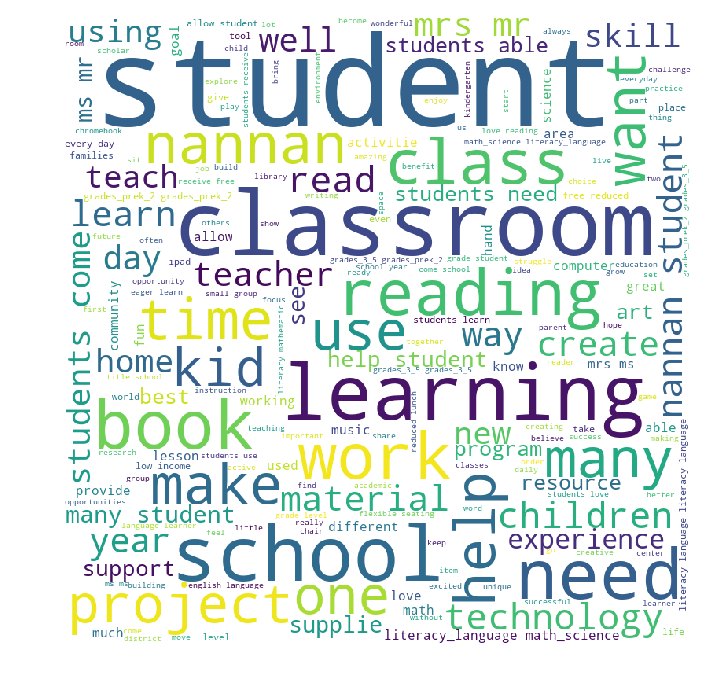

In [208]:
# ploting the wordcloud for all false positive data points for test data
# source https://www.geeksforgeeks.org/generating-word-cloud-python/

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

column_select = ['school_state','clean_categories','clean_subcategories','preprocessed_essays',
                 'preprocessed_titles','preprocessed_pgc','preprocessed_tp']

all_words_false_positive = ' '
stopwords = set(STOPWORDS) 
  
# iterate through all the data
for col_name in column_select:
    for val in X_test_false_positive[col_name].values:
        
        # type cast each value to string
        val = str(val)
        
        #split the value
        tokens = val.split()
        
        #convert each tokens into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            
        for words in tokens:
            all_words_false_positive = all_words_false_positive + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_words_false_positive) 
  

# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

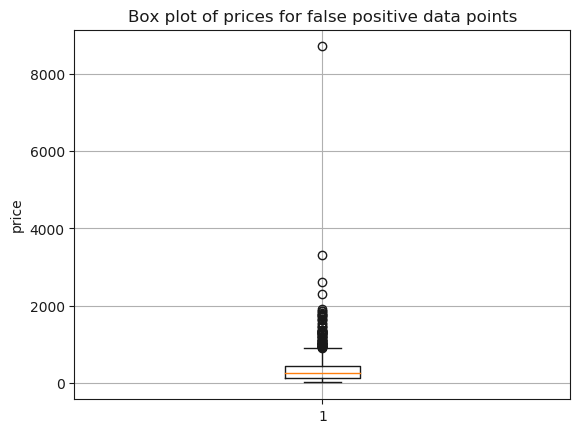

In [209]:
# Plotting the box plot with the `price` of these `false positive data points`
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.boxplot(X_test_false_possitive['price'].values)
plt.title("Box plot of prices for false positive data points")
plt.ylabel("price")
plt.grid()
plt.show()

<strong> Observations: </strong>
<ul>
    <li>The range of prices for maximum projects is 0 to 1000 </li>
    <li>75% prices of this class belongs to less than 500 </li>
    <li> There are some project prices which are greater than 1000 </li>
</ul>

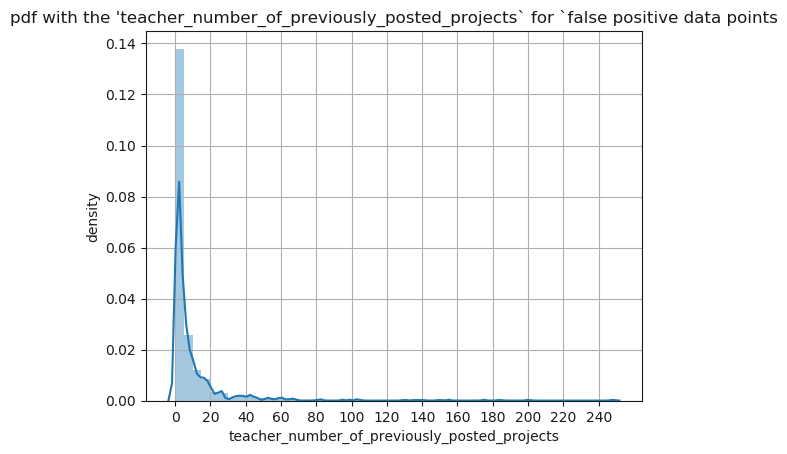

In [210]:
# Density Plot and Histogram of all arrival delays
import seaborn as sns
sns.distplot(X_test_false_possitive['teacher_number_of_previously_posted_projects'].values, hist = True)
plt.title("pdf with the 'teacher_number_of_previously_posted_projects` for `false positive data points")
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.ylabel("density")
plt.grid()
plt.xticks(np.arange(0, 250, step=20))
plt.show()

Observation: <br>
1 - 5 projects are previously posted by maximum number of teachers <br>
2 - For most projects in this class number_of_previously_posted_projects are between 0 to 20.

### 2.4.4 Applying DT on TFIDF W2V,<font color='red'> SET 4</font>

In [141]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tww2v, X_train_title_avgw2v, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tww2v, X_cv_title_avgw2v, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tww2v, X_test_title_avgw2v, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 701) (69918,)
(17480, 701) (17480,)
(21850, 701) (21850,)


In [142]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100, 500]
param_grid = dict(max_depth = depth, min_samples_split = min_samples_split)

clf_ = DecisionTreeClassifier(class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(min_samples_split))
cv_score_reshaped = cv_score.reshape(len(depth), len(min_samples_split))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

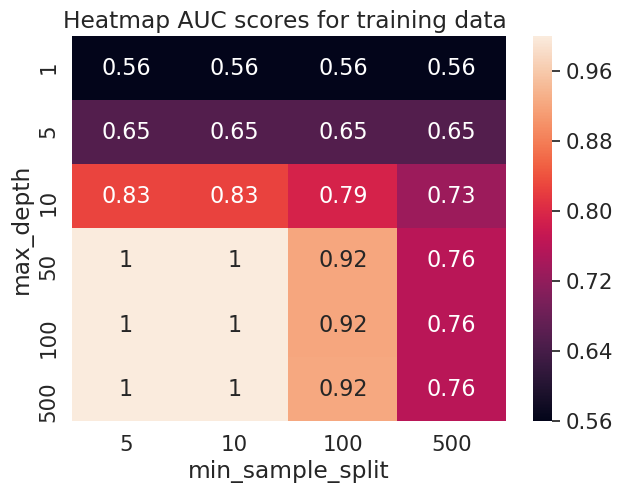

In [143]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

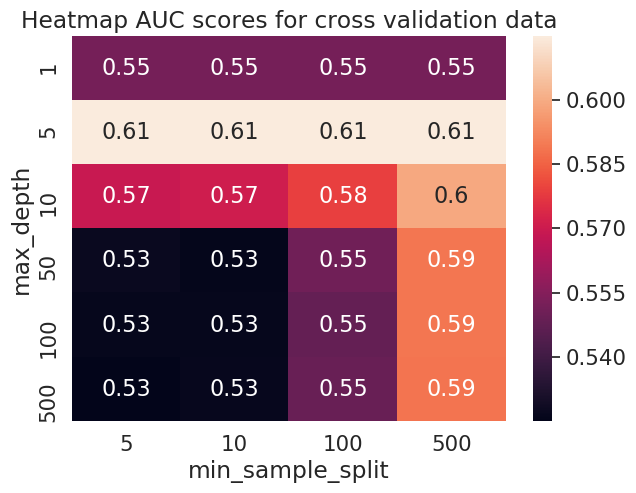

In [144]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7,5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

Training our final model for max_depth = 5 and min_sample_split = 500

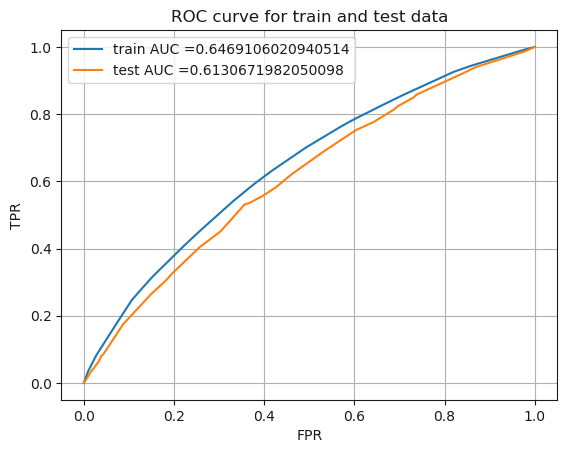

In [118]:

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth=5, min_samples_split = 500)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [119]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### Drawing confusion matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
By definition a confusion matrix  is such that  is equal to the number of observations known to be in group  but predicted to be in group .

Thus in binary classification, the count of true negatives is C00, false negatives is C10, true positives is C01 and false positives is C01.

In [120]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.3684985290723789 for threshold 0.521
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3416844297537132 for threshold 0.545


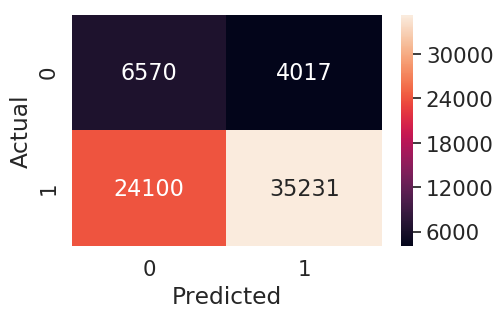

In [121]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
array = cmtr       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

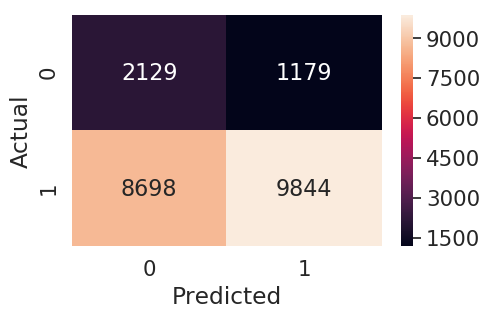

In [122]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (5,3))
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

### Selection and operations on false possitive data points
<li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud <a href='https://www.geeksforgeeks.org/generating-word-cloud-python/' with the words of eassy text of these `false positive data points`>WordCloud</a></li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
    </li>

In [167]:
# Getting all indexes of false possitive data points for test data
index_of_false_positive_data_points_test = [] 
y_test_pred_class = predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)
for i in range(y_test.shape[0]):
    if y_test[i] == 0 and y_test_pred_class[i] == 1:
        index_of_false_positive_data_points_test.append(i)
    else:
        pass

print(len(index_of_false_positive_data_points_test))

# Selecting all the rows or data points from test data which gives false possitive result.
X_test_false_positive = X_test.iloc[index_of_false_positive_data_points_test]

the maximum value of tpr*(1-fpr) 0.3416844297537132 for threshold 0.545
1179


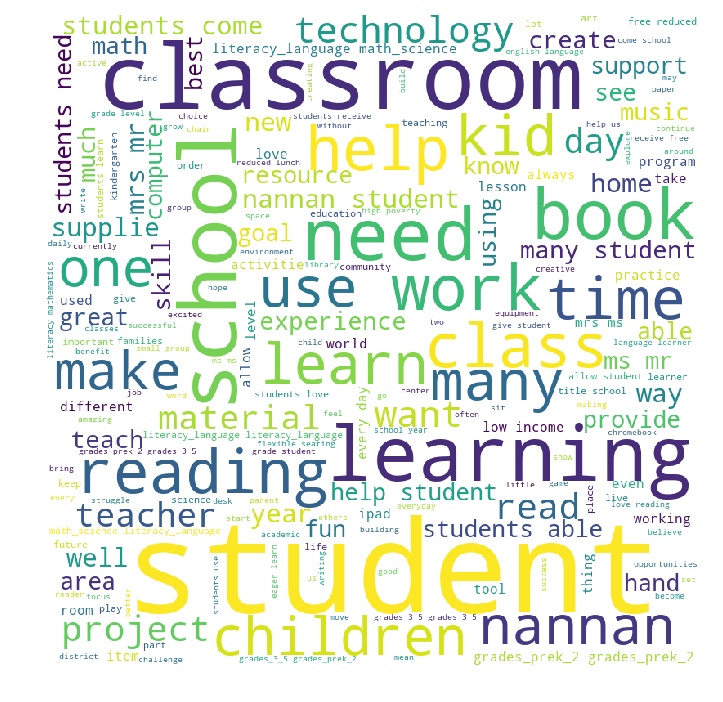

In [171]:
# ploting the wordcloud for all false positive data points for test data
# source https://www.geeksforgeeks.org/generating-word-cloud-python/

# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

column_select = ['school_state','clean_categories','clean_subcategories','preprocessed_essays',
                 'preprocessed_titles','preprocessed_pgc','preprocessed_tp']

all_words_false_positive = ' '
stopwords = set(STOPWORDS) 
  
# iterate through all the data
for col_name in column_select:
    for val in X_test_false_positive[col_name].values:
        
        # type cast each value to string
        val = str(val)
        
        #split the value
        tokens = val.split()
        
        #convert each tokens into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
            
        for words in tokens:
            all_words_false_positive = all_words_false_positive + words + ' '


wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(all_words_false_positive) 
  

# plot the WordCloud image                        
plt.figure(figsize = (7, 7), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

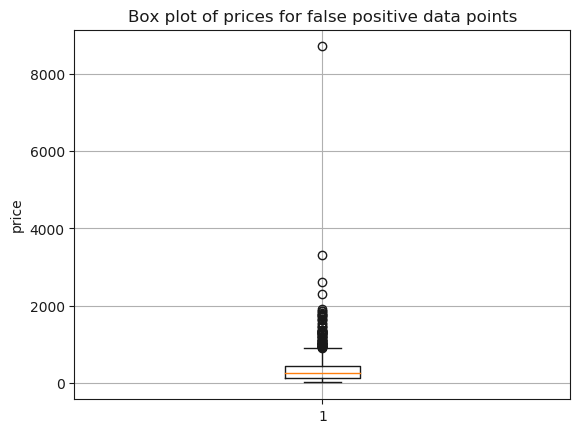

In [169]:
# Plotting the box plot with the `price` of these `false positive data points`
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.boxplot(X_test_false_possitive['price'].values)
plt.title("Box plot of prices for false positive data points")
plt.ylabel("price")
plt.grid()
plt.show()

<strong> Observations: </strong>
<ul>
    <li>The range of prices for maximum projects is 0 to 1000 </li>
    <li>75% prices of this class belongs to less than 500 </li>
    <li> There are some project prices which are greater than 1000 </li>
</ul>

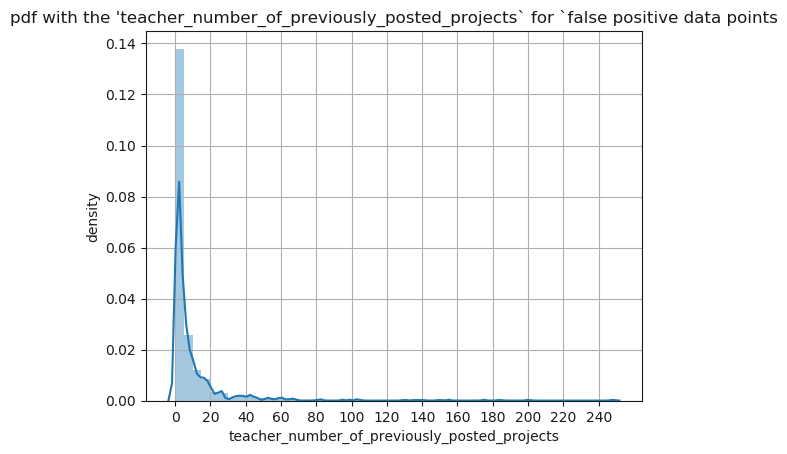

In [170]:
# Density Plot and Histogram of all arrival delays
import seaborn as sns
sns.distplot(X_test_false_possitive['teacher_number_of_previously_posted_projects'].values, hist = True)
plt.title("pdf with the 'teacher_number_of_previously_posted_projects` for `false positive data points")
plt.xlabel("teacher_number_of_previously_posted_projects")
plt.ylabel("density")
plt.grid()
plt.xticks(np.arange(0, 250, step=20))
plt.show()

Observation: <br>
1 - 5 projects are previously posted by maximum number of teachers <br>
2 - For most projects in this class number_of_previously_posted_projects are between 0 to 20.

<h2>2.5 [Task-2]Getting top 5k features using `feature_importances_`</h2>

<ul>
    <li> Select 5k best features from features of <font color='red'>Set 2</font> using<a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>`feature_importances_`</a>, discard all the other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), you need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3</li>
</ul>

In [145]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_ohe, X_train_categories_ohe, X_train_subcategories_ohe, X_train_teacher_prefix_ohe, X_train_pgc_ohe, X_train_price_norm, X_train_tnppp_norm)).tocsr()
X_cr = hstack((X_cv_essay_tfidf, X_cv_title_tfidf, X_cv_state_ohe, X_cv_categories_ohe, X_cv_subcategories_ohe, X_cv_teacher_prefix_ohe, X_cv_pgc_ohe, X_cv_price_norm, X_cv_tnppp_norm)).tocsr()
X_te = hstack((X_test_essay_tfidf, X_test_title_tfidf, X_test_state_ohe, X_test_categories_ohe, X_test_subcategories_ohe, X_test_teacher_prefix_ohe, X_test_pgc_ohe, X_test_price_norm, X_test_tnppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(69918, 7541) (69918,)
(17480, 7541) (17480,)
(21850, 7541) (21850,)


In [146]:
# Training our decision tree model for getting feature importances

clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth=10, min_samples_split = 500)

clf.fit(X_tr, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [147]:
# Getting features importances of all the columns
fi = clf.feature_importances_

# Selecting indexes of top 5k features
#https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array/
index_top_5k = np.argpartition(fi, -5000)[-5000:]

# Selecting data using index of top 5k features
# https://stackoverflow.com/questions/8386675/extracting-specific-columns-in-numpy-array
X_tr = X_tr[ : , index_top_5k]
X_cr = X_cr[ : , index_top_5k]
X_te = X_te[ : , index_top_5k]

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("="*80)

Final Data matrix
(69918, 5000) (69918,)
(17480, 5000) (17480,)
(21850, 5000) (21850,)


#### Now we apply decision tree on this top 5k features

In [148]:
# importing required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import numpy as np

# our hyperparameters to choose from
depth = [1, 5, 10, 50, 100, 500]
min_samples_split = [5, 10, 100, 500]
param_grid = dict(max_depth = depth, min_samples_split = min_samples_split)

clf_ = DecisionTreeClassifier(class_weight = 'balanced')

clf = GridSearchCV(clf_, param_grid, scoring = 'roc_auc', cv=3, n_jobs=-1)

sc = clf.fit(X_tr, y_train)

# getting all the results
scores = clf.cv_results_
# getting train scores and cross validation scores
train_score = scores['mean_train_score']
cv_score = scores['mean_test_score']
 
# Reshape matrix for printing out in heatmap
train_score_reshaped = train_score.reshape(len(depth), len(min_samples_split))
cv_score_reshaped = cv_score.reshape(len(depth), len(min_samples_split))

Text(0.5, 1, 'Heatmap AUC scores for training data ')

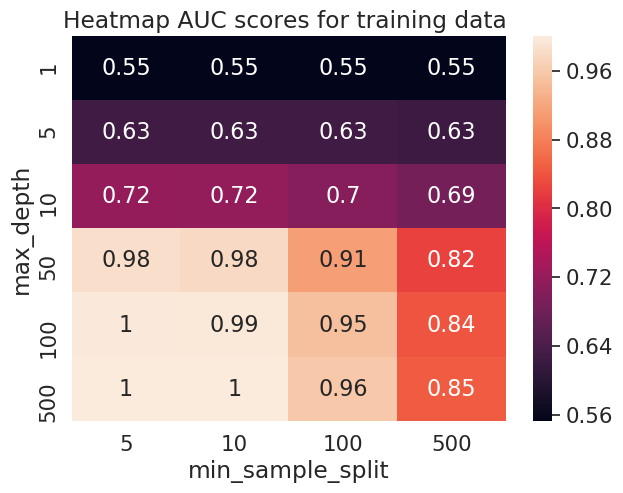

In [149]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(train_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7, 5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for training data ")

Text(0.5, 1, 'Heatmap AUC scores for cross validation data')

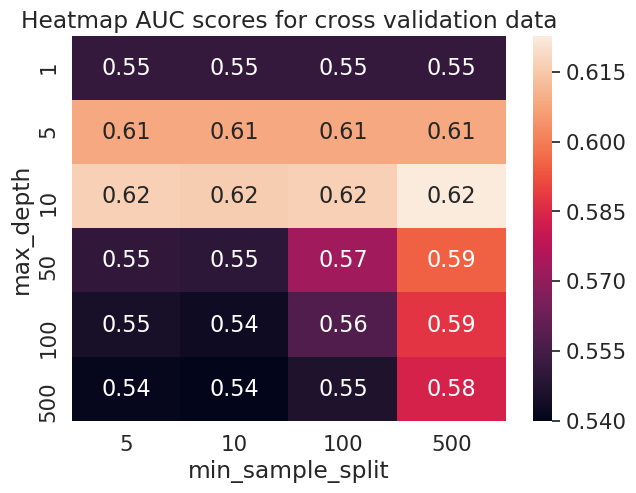

In [150]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
  
df_cm = pd.DataFrame(cv_score_reshaped, depth, min_samples_split)
plt.figure(figsize = (7,5))
sn.set(font_scale = 1.4) #for label size
df_cm.index.name = 'max_depth'
df_cm.columns.name = 'min_sample_split'
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.2g')# font size
plt.title("Heatmap AUC scores for cross validation data")

#### Now we train our final model for max_depth = 10 and min_samples_split = 500

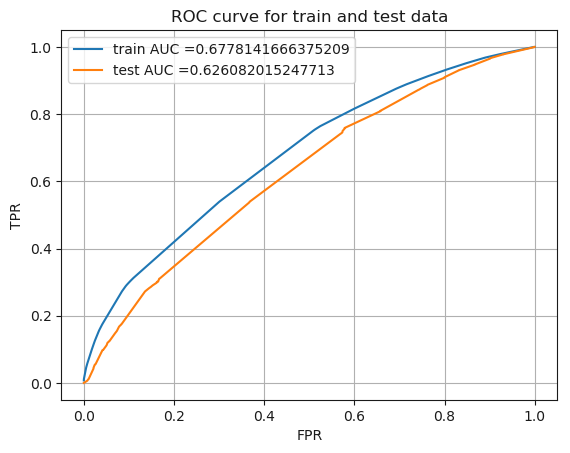

In [230]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(class_weight = 'balanced', max_depth=10, min_samples_split = 500)

clf.fit(X_tr, y_train)

y_train_pred = clf.predict_proba(X_tr)[:,1]
y_test_pred = clf.predict_proba(X_te)[:,1]


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for train and test data")
plt.grid()
plt.show()

##### Drawing confusion matrix

In [231]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
# this function returns actual prediction in form of 0 and 1 by accepting the probability score on the data
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [232]:
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
cmtr = confusion_matrix(y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr))
print("Test confusion matrix")
cmte = confusion_matrix(y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))

Train confusion matrix
the maximum value of tpr*(1-fpr) 0.37750977235793726 for threshold 0.514
Test confusion matrix
the maximum value of tpr*(1-fpr) 0.3409304957782697 for threshold 0.514


In [233]:
%matplotlib inline

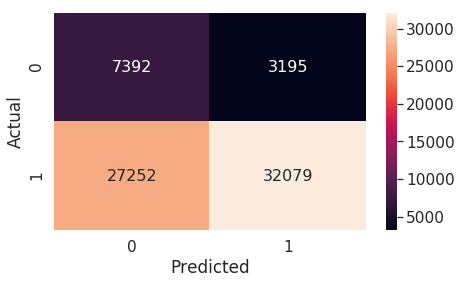

In [234]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
import seaborn as sn
array = cmtr                 # Confusion matrix for train data       
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (7,4))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.set(font_scale=1.4) #for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

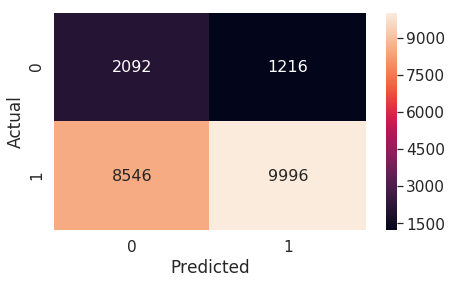

In [235]:
# source https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
array = cmte      # Confusion matrix for test data  
df_cm = pd.DataFrame(array, range(2),range(2))
plt.figure(figsize = (7,4)) 
sn.set(font_scale=1.4) #for label size
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
sn.heatmap(df_cm, annot = True, annot_kws={"size": 16}, fmt='g') # font size

<h1>3. Conclusions</h1>

In [229]:
# compare models using Prettytable library
# source http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizor", "Model", "max_depth","min_sample_split", "AUC"]

x.add_row(["BOW", "decision tree", 10, 500, 0.63])
x.add_row(["TFIDF", "decision tree", 10, 500, 0.62])
x.add_row(["W2V", "decision tree", 5, 500, 0.61])
x.add_row(["TFIDFW2V", "decision tree", 5, 500, 0.61])

print(x)

+------------+---------------+-----------+------------------+------+
| Vectorizor |     Model     | max_depth | min_sample_split | AUC  |
+------------+---------------+-----------+------------------+------+
|    BOW     | decision tree |     10    |       500        | 0.63 |
|   TFIDF    | decision tree |     10    |       500        | 0.62 |
|    W2V     | decision tree |     5     |       500        | 0.61 |
|  TFIDFW2V  | decision tree |     5     |       500        | 0.61 |
+------------+---------------+-----------+------------------+------+
